In [ ]:
# !pip install imantics
# !pip install patchify

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.models import load_model
import tensorflow as tf


@tf.keras.utils.register_keras_serializable(package="Custom")
def bulinding_iou(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)

    # Only keep patches that have some damage
    mask = tf.reduce_sum(y_true, axis=[1,2,3]) > 0
    y_true = tf.boolean_mask(y_true, mask)
    y_pred = tf.boolean_mask(y_pred, mask)

    # If no damage patches exist, return 0
    def compute_iou():
        intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
        union = tf.reduce_sum(y_true, axis=[1,2,3]) + tf.reduce_sum(y_pred, axis=[1,2,3]) - intersection
        return tf.reduce_mean(intersection / (union + 1e-7))

    return tf.cond(tf.size(y_true) > 0, compute_iou, lambda: 0.0)

@tf.keras.utils.register_keras_serializable(package="Custom")
def bulinding_f1_per_class(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)

    # Only damage class
    intersection = tf.reduce_sum(y_true * y_pred)
    precision = intersection / (tf.reduce_sum(y_pred) + 1e-7)
    recall = intersection / (tf.reduce_sum(y_true) + 1e-7)
    return 2 * precision * recall / (precision + recall + 1e-7)
model = load_model(
    "/content/drive/MyDrive/bulinding_seg_resnet34.keras",
    custom_objects={
        "bulinding_iou": bulinding_iou,
        "bulinding_f1_per_class": bulinding_f1_per_class
    },
    compile=False  # safer for custom losses
)

In [ ]:
import os
import json
from pprint import pprint


def load_cropped_building_paths(save_dir="/content/drive/MyDrive/improved_crop_buildings"):
    """
    Load pre/post image paths and labels from saved metadata JSON.
    Does NOT load image arrays into memory — only returns file paths and labels.
    """
    json_path = os.path.join(save_dir, "cropped_buildings_metadata.json")

    if not os.path.exists(json_path):
        raise FileNotFoundError(f"Metadata JSON not found: {json_path}")

    with open(json_path, "r") as f:
        all_crops = json.load(f)

    loaded_paths = {}

    for img_id, buildings in all_crops.items():
        loaded_paths[img_id] = {}
        for b_id, data in buildings.items():
            pre_path = data["pre"]
            post_path = data["post"]
            label = data["label"]

            # verify paths exist
            if os.path.exists(pre_path) and os.path.exists(post_path):
                loaded_paths[img_id][b_id] = {
                    "pre_path": pre_path,
                    "post_path": post_path,
                    "label": label
                }
            else:
                print(f"⚠️ Missing file for {img_id} | Building {b_id}, skipping.")

    print(f"\n Loaded {len(loaded_paths)} images with cropped building path data.")
    return loaded_paths


In [ ]:
save_dir = "/content/drive/MyDrive/improved_crop_buildings"
data_paths = load_cropped_building_paths(save_dir)

pprint(dict(list(data_paths.items())[:1]))


 Loaded 88 images with cropped building path data.
{'hurricane-florence_00000106': {'0': {'label': 3,
                                       'post_path': '/content/drive/MyDrive/improved_crop_buildings/hurricane-florence_00000106_building_0_post.png',
                                       'pre_path': '/content/drive/MyDrive/improved_crop_buildings/hurricane-florence_00000106_building_0_pre.png'},
                                 '1': {'label': 3,
                                       'post_path': '/content/drive/MyDrive/improved_crop_buildings/hurricane-florence_00000106_building_1_post.png',
                                       'pre_path': '/content/drive/MyDrive/improved_crop_buildings/hurricane-florence_00000106_building_1_pre.png'},
                                 '2': {'label': 3,
                                       'post_path': '/content/drive/MyDrive/improved_crop_buildings/hurricane-florence_00000106_building_2_post.png',
                                       'pre_pat

/tmp/ipython-input-3532598742.py:46: UserWarning: Glyph 129521 (\N{BRICK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129521 (\N{BRICK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


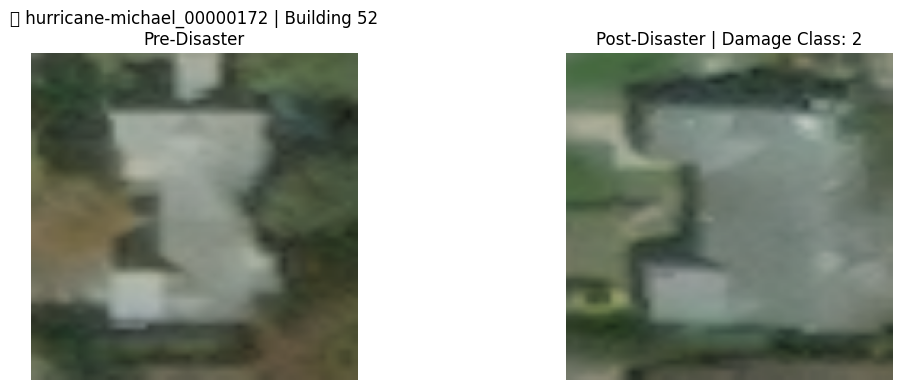

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import random

def plot_pre_post_samples(paths_dict, n_samples=3):
    """
    Randomly plots a few pre/post image pairs with their damage labels
    from the cropped dataset.
    """
    # Collect all (img_id, building_id, data) tuples
    all_buildings = [
        (img_id, b_id, data)
        for img_id, buildings in paths_dict.items()
        for b_id, data in buildings.items()
    ]

    # Shuffle for randomness
    random.shuffle(all_buildings)

    # Pick N samples
    samples = all_buildings[:n_samples]

    # Plot
    plt.figure(figsize=(12, n_samples * 4))

    for idx, (img_id, b_id, data) in enumerate(samples, 1):
        pre_path = data['pre_path']
        post_path = data['post_path']
        label = data['label']

        pre_img = Image.open(pre_path)
        post_img = Image.open(post_path)

        # Pre
        plt.subplot(n_samples, 2, (idx - 1) * 2 + 1)
        plt.imshow(pre_img)
        plt.axis("off")
        plt.title(f"🧱 {img_id} | Building {b_id}\nPre-Disaster")

        # Post
        plt.subplot(n_samples, 2, (idx - 1) * 2 + 2)
        plt.imshow(post_img)
        plt.axis("off")
        plt.title(f"Post-Disaster | Damage Class: {label}")

    plt.tight_layout()
    plt.show()
plot_pre_post_samples(data_paths, n_samples=1)

In [ ]:
import pandas as pd

def data_paths_to_df(data_paths):
    records = []

    for image_id, buildings in data_paths.items():
        for b_id, info in buildings.items():
            records.append({
                'image_id': image_id,
                'building_id': b_id,
                'label': info.get('label'),
                'pre_path': info.get('pre_path'),
                'post_path': info.get('post_path')
            })

    df = pd.DataFrame(records)
    return df

# Example usage
df = data_paths_to_df(data_paths)



# need to improve the qulity of the input images

In [ ]:
import cv2
import numpy as np

def sharpen_image(image):
    gaussian = cv2.GaussianBlur(image, (3, 3), 1.0)
    sharpened = cv2.addWeighted(image, 1.5, gaussian, -0.5, 0)
    return sharpened
def apply_clahe(image,clip=3.0):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    merged = cv2.merge((cl, a, b))
    return cv2.cvtColor(merged, cv2.COLOR_LAB2BGR)



In [ ]:
import cv2

# Read image from path first
pre_img  = cv2.imread(df['pre_path'][802])   # example for first image
post_img = cv2.imread(df['post_path'][802])

# Optional: convert to RGB (OpenCV reads as BGR)
pre_img  = cv2.cvtColor(pre_img, cv2.COLOR_BGR2RGB)
post_img = cv2.cvtColor(post_img, cv2.COLOR_BGR2RGB)

# Then apply enhancement
# cropped_pre  = apply_clahe(sharpen_image(pre_img))
# cropped_post = apply_clahe(sharpen_image(post_img))

cropped_pre  = apply_clahe(sharpen_image(pre_img), clip=3.0)
cropped_post = apply_clahe(sharpen_image(post_img), clip=3.0)

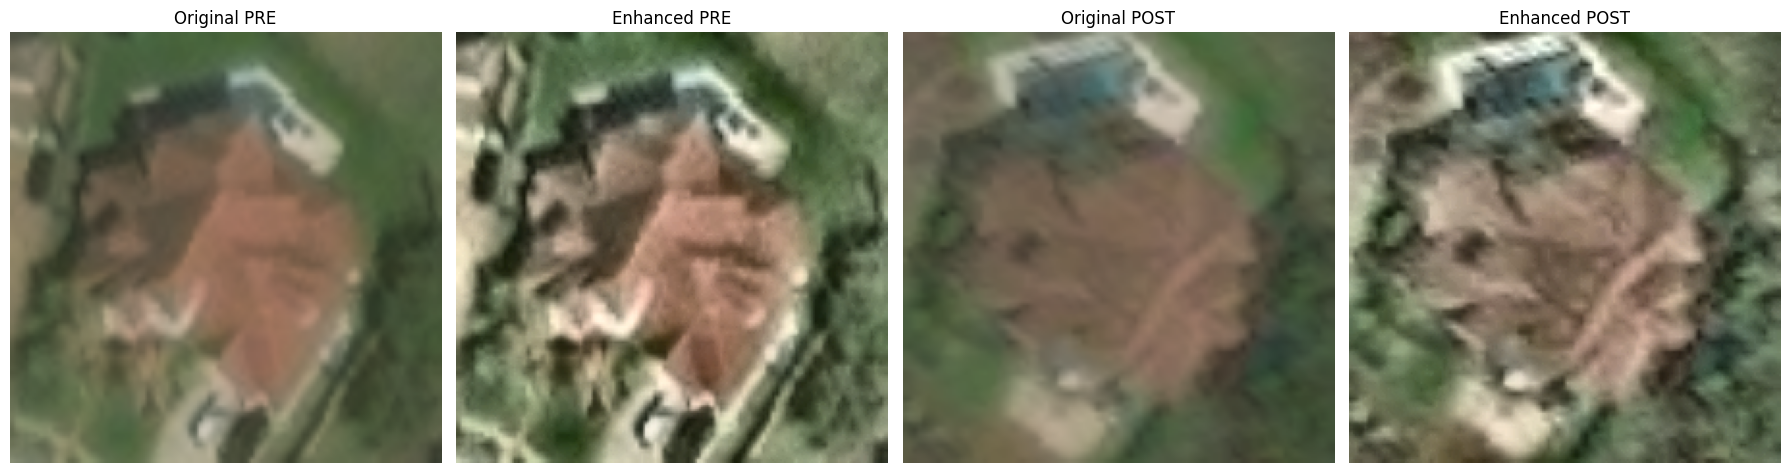

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 4, figsize=(18, 5))

axes[0].imshow(pre_img)
axes[0].set_title('Original PRE')
axes[0].axis('off')

axes[1].imshow(cropped_pre)
axes[1].set_title('Enhanced PRE')
axes[1].axis('off')

axes[2].imshow(post_img)
axes[2].set_title('Original POST')
axes[2].axis('off')

axes[3].imshow(cropped_post)
axes[3].set_title('Enhanced POST')
axes[3].axis('off')

plt.tight_layout()
plt.show()


## pre processing

In [ ]:
import os
from tqdm import tqdm
import cv2

pre_images = []
post_images = []
labels = []

for img_id, buildings in tqdm(data_paths.items()):
    for b_id, data in buildings.items():
        pre_path  = data['pre_path']
        post_path = data['post_path']

        # Read and enhance
        pre_img  = cv2.imread(pre_path)
        post_img = cv2.imread(post_path)

        if pre_img is None or post_img is None:
            print(f"⚠️ Missing file for {img_id} | Building {b_id}, skipping.")
            continue  # skip missing files

        # Convert to RGB
        pre_img  = cv2.cvtColor(pre_img, cv2.COLOR_BGR2RGB)
        post_img = cv2.cvtColor(post_img, cv2.COLOR_BGR2RGB)

        # Apply enhancement
        pre_enh  = apply_clahe(sharpen_image(pre_img), clip=3.0)
        post_enh = apply_clahe(sharpen_image(post_img), clip=3.0)

        # Resize for ResNet
        # pre_enh  = cv2.resize(pre_enh, (224, 224))
        # post_enh = cv2.resize(post_enh, (224, 224))

        pre_images.append(pre_enh)
        post_images.append(post_enh)
        labels.append(data['label'])


100%|██████████| 88/88 [00:15<00:00,  5.83it/s]


array([[[ 70, 112,  73],
        [ 70, 112,  73],
        [ 77, 119,  80],
        ...,
        [124, 137,  96],
        [124, 137,  96],
        [124, 137,  96]],

       [[ 70, 112,  73],
        [ 69, 112,  74],
        [ 77, 119,  80],
        ...,
        [126, 140, 100],
        [124, 137,  96],
        [124, 137,  96]],

       [[ 73, 115,  76],
        [ 72, 112,  72],
        [ 78, 122,  83],
        ...,
        [120, 133,  92],
        [120, 133,  92],
        [120, 133,  92]],

       ...,

       [[ 65,  92,  62],
        [ 65,  92,  62],
        [ 67,  91,  64],
        ...,
        [166, 186, 150],
        [176, 196, 160],
        [174, 194, 158]],

       [[ 76, 101,  71],
        [ 71,  99,  69],
        [ 71,  98,  71],
        ...,
        [176, 196, 160],
        [181, 199, 164],
        [180, 198, 163]],

       [[ 71,  99,  69],
        [ 71,  99,  69],
        [ 76, 101,  73],
        ...,
        [178, 195, 161],
        [180, 198, 163],
        [180, 198, 163]]], dtype=uint8)
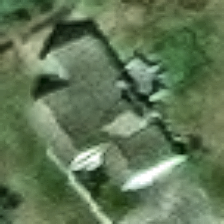

In [ ]:
pre_images[2]

array([[[ 21,  47,  10],
        [ 21,  47,  10],
        [ 23,  50,  11],
        ...,
        [ 46,  64,  45],
        [ 46,  64,  45],
        [ 46,  64,  45]],

       [[ 21,  47,  10],
        [ 21,  47,  10],
        [ 24,  50,  14],
        ...,
        [ 46,  64,  45],
        [ 46,  64,  45],
        [ 46,  64,  45]],

       [[ 18,  44,   6],
        [ 18,  44,   6],
        [ 21,  47,  10],
        ...,
        [ 49,  68,  47],
        [ 46,  64,  45],
        [ 46,  64,  45]],

       ...,

       [[ 79, 106,  72],
        [ 83, 110,  74],
        [ 75,  99,  63],
        ...,
        [ 44,  62,  40],
        [ 42,  59,  37],
        [ 42,  59,  37]],

       [[ 90, 117,  78],
        [ 90, 117,  81],
        [ 75,  99,  65],
        ...,
        [ 44,  62,  40],
        [ 42,  59,  37],
        [ 42,  59,  37]],

       [[ 90, 117,  81],
        [ 90, 117,  81],
        [ 75,  99,  65],
        ...,
        [ 44,  62,  38],
        [ 42,  59,  37],
        [ 42,  59,  37]]], dtype=uint8)
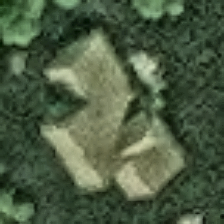

In [ ]:
post_images[2]

In [ ]:
pre_images = np.array(pre_images, dtype=np.float32)
post_images = np.array(post_images, dtype=np.float32)

In [ ]:
from sklearn.model_selection import train_test_split

train_pre, test_pre, train_post, test_post, train_y, test_y = train_test_split(
    pre_images, post_images, labels, test_size=0.2, random_state=42, stratify=labels
)

In [ ]:
train_pre.shape, test_pre.shape, train_post.shape, test_post.shape, len(train_y), len(test_y)

((689, 224, 224, 3),
 (173, 224, 224, 3),
 (689, 224, 224, 3),
 (173, 224, 224, 3),
 689,
 173)

In [ ]:
train_y = np.array(train_y) - 1
test_y = np.array(test_y) - 1

**wcce+focal**

In [ ]:
import tensorflow as tf

@tf.keras.utils.register_keras_serializable()
class HybridWeightedFocalLoss(tf.keras.losses.Loss):
    def __init__(self,
                 class_weights=None,
                 label_smoothing=0.0,
                 gamma=2.0,
                 lam=0.5,
                 reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE,
                 name="hybrid_weighted_focal_loss",
                 **kwargs):
        """
        lam in [0,1] mixes between WCCE and Focal:
          loss = (1-lam) * WCCE + lam * FocalWeighted
        gamma is focal gamma.
        class_weights: list/array-like of len=num_classes or None.
        """
        super().__init__(reduction=reduction, name=name, **kwargs)
        self.class_weights = tf.constant(class_weights, dtype=tf.float32) if class_weights is not None else None
        self.label_smoothing = float(label_smoothing)
        self.gamma = float(gamma)
        self.lam = float(lam)

    def call(self, y_true, y_pred):
        # y_true: (batch,) integer labels
        # y_pred: (batch, num_classes) softmax probabilities
        y_true = tf.cast(y_true, tf.int32)
        y_pred = tf.clip_by_value(y_pred, 1e-8, 1.0 - 1e-8)
        num_classes = tf.shape(y_pred)[-1]
        y_true_one_hot = tf.one_hot(y_true, depth=num_classes, dtype=tf.float32)

        # label smoothing
        if self.label_smoothing > 0:
            smooth_pos = 1.0 - self.label_smoothing
            smooth_neg = self.label_smoothing / tf.cast(num_classes - 1, tf.float32)
            y_true_one_hot = y_true_one_hot * smooth_pos + smooth_neg

        # standard cross-entropy per sample
        ce_per_sample = -tf.reduce_sum(y_true_one_hot * tf.math.log(y_pred), axis=-1)

        # class weights per sample (gather by int label)
        if self.class_weights is not None:
            sample_weights = tf.gather(self.class_weights, y_true)
        else:
            sample_weights = 1.0

        # Weighted Categorical Cross-Entropy (scalar per sample)
        wce = ce_per_sample * sample_weights

        # Focal part: focal factor computed w.r.t. true class probability pt
        pt = tf.reduce_sum(y_true_one_hot * y_pred, axis=-1)  # p_t
        focal_factor = tf.pow(1.0 - pt, self.gamma)
        focal_loss = focal_factor * ce_per_sample

        # apply same class weights to focal part (keeps balance)
        focal_loss = focal_loss * sample_weights

        # Mix them
        loss = (1.0 - self.lam) * wce + self.lam * focal_loss

        return tf.reduce_mean(loss)

    def get_config(self):
        cfg = super().get_config()
        cfg.update({
            "class_weights": self.class_weights.numpy().tolist() if self.class_weights is not None else None,
            "label_smoothing": self.label_smoothing,
            "gamma": self.gamma,
            "lam": self.lam,
        })
        return cfg


In [ ]:
import tensorflow as tf
import numpy as np

# ---------------- Multi-class Precision ---------------- #
@tf.keras.utils.register_keras_serializable()

class MultiClassPrecision(tf.keras.metrics.Metric):
    def __init__(self, num_classes=4, name="precision", **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.tp = self.add_weight(shape=(num_classes,), initializer="zeros", dtype=tf.float32)
        self.fp = self.add_weight(shape=(num_classes,), initializer="zeros", dtype=tf.float32)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(tf.reshape(y_true, [-1]), tf.int32)
        y_pred = tf.cast(tf.argmax(y_pred, axis=-1), tf.int32)

        cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=self.num_classes, dtype=tf.float32)
        tp = tf.linalg.diag_part(cm)
        fp = tf.reduce_sum(cm, axis=0) - tp

        self.tp.assign_add(tp)
        self.fp.assign_add(fp)

    def result(self):
        precision = self.tp / (self.tp + self.fp + 1e-8)
        return precision  # <-- return per-class precision

    def reset_state(self):
        for v in self.variables:
            v.assign(tf.zeros_like(v))


# ---------------- Multi-class Recall ---------------- #
@tf.keras.utils.register_keras_serializable()

class MultiClassRecall(tf.keras.metrics.Metric):
    def __init__(self, num_classes=4, name="recall", **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.tp = self.add_weight(shape=(num_classes,), initializer="zeros", dtype=tf.float32)
        self.fn = self.add_weight(shape=(num_classes,), initializer="zeros", dtype=tf.float32)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(tf.reshape(y_true, [-1]), tf.int32)
        y_pred = tf.cast(tf.argmax(y_pred, axis=-1), tf.int32)

        cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=self.num_classes, dtype=tf.float32)
        tp = tf.linalg.diag_part(cm)
        fn = tf.reduce_sum(cm, axis=1) - tp

        self.tp.assign_add(tp)
        self.fn.assign_add(fn)

    def result(self):
        recall = self.tp / (self.tp + self.fn + 1e-8)
        return recall  # <-- return per-class recall

    def reset_state(self):
        for v in self.variables:
            v.assign(tf.zeros_like(v))


# ---------------- Per-Class Harmonic Mean ---------------- #
import tensorflow as tf

@tf.keras.utils.register_keras_serializable()
class PerClassHarmonicMean(tf.keras.metrics.Metric):
    def __init__(self, num_classes=4, name="harmonic_mean", **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.eps = 1e-8

        # Store confusion components
        self.tp = self.add_weight(shape=(num_classes,), initializer="zeros", dtype=tf.float32)
        self.fp = self.add_weight(shape=(num_classes,), initializer="zeros", dtype=tf.float32)
        self.fn = self.add_weight(shape=(num_classes,), initializer="zeros", dtype=tf.float32)

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Flatten
        y_true = tf.cast(tf.reshape(y_true, [-1]), tf.int32)
        y_pred = tf.cast(tf.argmax(y_pred, axis=-1), tf.int32)
        y_pred = tf.reshape(y_pred, [-1])

        # Compute confusion matrix
        cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=self.num_classes, dtype=tf.float32)
        tp = tf.linalg.diag_part(cm)
        fp = tf.reduce_sum(cm, axis=0) - tp
        fn = tf.reduce_sum(cm, axis=1) - tp

        # Accumulate totals
        self.tp.assign_add(tp)
        self.fp.assign_add(fp)
        self.fn.assign_add(fn)

    def result(self):
        precision = self.tp / (self.tp + self.fp + self.eps)
        recall = self.tp / (self.tp + self.fn + self.eps)
        harmonic = 2.0 / ((1.0 / (precision + self.eps)) + (1.0 / (recall + self.eps)))

        # Return macro-average harmonic mean (mean of all classes)
        return tf.reduce_mean(harmonic)

    def reset_state(self):
        for v in self.variables:
            v.assign(tf.zeros_like(v))




import matplotlib.pyplot as plt

# ---------------- Per-Class Metrics Callback ---------------- #
class PerClassMetrics(tf.keras.callbacks.Callback):
    def __init__(self, x_val, y_val, num_classes=4, store_history=True):
        super().__init__()
        self.x_val = x_val
        self.y_val = y_val
        self.num_classes = num_classes
        self.store_history = store_history
        self.history = []  # store per-class metrics over epochs
        self.last_recall = None  # store last per-class recall for external logic

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.x_val, verbose=0)
        y_pred = np.argmax(y_pred, axis=1)
        y_true = np.array(self.y_val).reshape(-1)

        cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=self.num_classes).numpy()
        tp = np.diag(cm)
        fp = np.sum(cm, axis=0) - tp
        fn = np.sum(cm, axis=1) - tp

        precision = tp / (tp + fp + 1e-8)
        recall = tp / (tp + fn + 1e-8)
        harmonic = 2.0 / ((1.0 / (precision + 1e-8)) + (1.0 / (recall + 1e-8)))

        print(f"\nEpoch {epoch+1} — Per-class metrics:")
        for i in range(self.num_classes):
            print(f"  Class {i}: Precision = {precision[i]:.3f}, Recall = {recall[i]:.3f}, Harmonic = {harmonic[i]:.3f}")
        print("-" * 60)

        # store results
        if self.store_history:
            self.history.append({
                'epoch': epoch + 1,
                'precision': precision.tolist(),
                'recall': recall.tolist(),
                'harmonic': harmonic.tolist()
            })
        self.last_recall = recall  # used for early stopping



*<h1> EFFICIENTNETB0*

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

# --- Config ---
INPUT_SHAPE = (224, 224, 3)
NUM_CLASSES = 4


def make_backbone(name, trainable=False):
    inp = layers.Input(shape=INPUT_SHAPE, name=f"{name}_input")
    x = layers.Lambda(preprocess_input)(inp)

    base = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_tensor=x
    )

    x = layers.GlobalAveragePooling2D()(base.output)

    model = models.Model(inp, x, name=f"{name}_backbone")
    model.trainable = trainable
    return model


# --- Create pre and post backbones ---
pre_b = make_backbone('pre', trainable=False)
post_b = make_backbone('post', trainable=False)

# --- Define inputs ---
pre_in  = layers.Input(shape=INPUT_SHAPE, name='pre_image')
post_in = layers.Input(shape=INPUT_SHAPE, name='post_image')

# --- Extract features ---
pre_feat  = pre_b(pre_in)
post_feat = post_b(post_in)

# --- Combine features (optionally difference can also be tried) ---
combined = layers.Concatenate()([pre_feat, post_feat])
# combined = layers.Concatenate()([pre_feat, post_feat, layers.Subtract()([post_feat, pre_feat])])  # optional variant

# --- Classification head ---
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(combined)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.6)(x)

x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

out = layers.Dense(NUM_CLASSES, activation='softmax')(x)

# --- Final model ---
model = models.Model([pre_in, post_in], out)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ pre_image           │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ post_image          │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pre_backbone        │ (None, 1280)      │  4,049,571 │ pre_image[0][0]   │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ post_backbone       │ (None, 1280)      │  4,049,571 │ post_image[0][0]  │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2560)      │          0 │ pre_backbone[0][… │
│ (Concatenate)       │                   │            │ post_backbone[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    655,616 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 4)         │        516 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,789,706 (33.53 MB)

 Trainable params: 689,796 (2.63 MB)

 Non-trainable params: 8,099,910 (30.90 MB)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def optional_effects(img):
                    """Optional mild effects applied randomly."""
                    # Apply slight Gaussian blur with low probability
                    if np.random.rand() < 0.15:
                        img = cv2.GaussianBlur(img, (3, 3), sigmaX=0.5)

                    # Random contrast (±10%)
                    if np.random.rand() < 0.3:
                        alpha = np.random.uniform(0.9, 1.1)
                        img = np.clip(img * alpha, 0, 255)

                    # Channel-wise sensor noise (mild)
                    if np.random.rand() < 0.25:
                        noise_std = np.random.uniform(0.3, 0.8)
                        noise = np.random.normal(0, noise_std, img.shape)
                        img = np.clip(img + noise, 0, 255)

                    return img


def augment_batch(pre_imgs, post_imgs, labels, epoch=None, total_epochs=None):
    aug_pre, aug_post, aug_labels = [], [], []

    unique_classes, counts = np.unique(labels, return_counts=True)
    class_stats = dict(zip(unique_classes, counts))
    max_count = np.max(counts)

    # --- Adaptive oversampling targets ---
    target_counts = {}
    for cls, cnt in class_stats.items():
        ratio = cnt / max_count
        if ratio < 0.3:
            factor = 2.0
        elif ratio < 0.5:
            factor = 1.5
        elif ratio < 0.8:
            factor = 1.2
        else:
            factor = 1.0
        target_counts[cls] = min(int(cnt * factor), int(1.4 * max_count))

    # print("\n Adaptive target counts:")
    # for cls, t in target_counts.items():
    #     print(f"  Class {cls}: {t}")

    # --- Dynamic scaling by epoch (lighter later epochs) ---
    epoch_factor = 1.0
    if epoch is not None and total_epochs is not None:
        epoch_factor = max(0.5, 1.0 - (epoch / total_epochs) * 0.5)







    for cls in unique_classes:
        cls_idx = np.where(labels == cls)[0]
        current = len(cls_idx)
        target = target_counts.get(cls, current)
        total_idx = np.concatenate([cls_idx,
                                    np.random.choice(cls_idx, target - current, replace=True)
                                    if current < target else []])

        total_idx = total_idx.astype(int)

        for idx in total_idx:
            pre, post, y = pre_imgs[idx].astype(np.float32), post_imgs[idx].astype(np.float32), labels[idx]
            seed = np.random.randint(0, 10000)


            if y in [1, 2]:
                  # much lighter augmentations
                  local_aug = ImageDataGenerator(
                      rotation_range=int(5 * epoch_factor),
                      width_shift_range=0.03 * epoch_factor,
                      height_shift_range=0.03 * epoch_factor,
                      zoom_range=0.05 * epoch_factor,
                      brightness_range=[0.9, 1.1],
                      fill_mode='reflect',
                      horizontal_flip=True
                  )
                  # remove Gaussian noise completely (or keep very low)
                  noise_std = 0.5 * epoch_factor
                  pre += np.random.normal(0, noise_std, pre.shape)
                  post += np.random.normal(0, noise_std, post.shape)
                  pre = np.clip(pre, 0, 255)
                  post = np.clip(post, 0, 255)



            elif y == 3:  # class 3 → stronger augmentations
                local_aug = ImageDataGenerator(
                    rotation_range=int(20 * epoch_factor),
                    width_shift_range=0.15 * epoch_factor,
                    height_shift_range=0.15 * epoch_factor,
                    zoom_range=0.2 * epoch_factor,
                    brightness_range=[0.6, 1.4],
                    fill_mode='reflect',
                    horizontal_flip=True,
                    shear_range=10 * epoch_factor
                )
                # add a little Gaussian noise to simulate severe distortion
                noise_std = 1.0 * epoch_factor
                pre += np.random.normal(0, noise_std, pre.shape)
                post += np.random.normal(0, noise_std, post.shape)
                pre = np.clip(pre, 0, 255)
                post = np.clip(post, 0, 255)

            else:  # class 0 → slightly stronger augmentations

                   local_aug = ImageDataGenerator(
                       brightness_range=[0.6, 1.4],
                        zoom_range=0.2,
                      width_shift_range=0.1,
                         height_shift_range=0.1,
                     rotation_range=15,
                            fill_mode='reflect'


            pre_aug = local_aug.random_transform(pre, seed=seed)
            post_aug = local_aug.random_transform(post, seed=seed)


            # Apply optional mild effects (randomly)
            pre_aug = optional_effects(pre_aug)
            post_aug = optional_effects(post_aug)

            aug_pre.append(pre_aug)
            aug_post.append(post_aug)
            aug_labels.append(y)

    aug_labels = np.array(aug_labels)
    unique, counts = np.unique(aug_labels, return_counts=True)

    # print("\n Final semi-balanced distribution:")
    # total = np.sum(counts)
    # for u, c in zip(unique, counts):
    #     print(f"  Class {u}: {c} ({(c / total) * 100:.1f}%)")

    return np.array(aug_pre), np.array(aug_post), aug_labels





In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint


# -------- Phase 1: Train Classifier Head Only -------- #
for layer in model.get_layer('pre_backbone').layers:
    layer.trainable = False
for layer in model.get_layer('post_backbone').layers:
    layer.trainable = False


#class_weights = [0.38, 3.25, 2.21, 1.67]

# loss_fn = WeightedSparseCategoricalCrossEntropy(
#     class_weights=class_weights,
#     label_smoothing=0.05
# )
#class_weights = [0.20167261, 1.73120972, 1.17631705, 0.89080062]  # your computed weights
loss_fn = HybridWeightedFocalLoss( label_smoothing=0.05,
                                  gamma=1.3, lam=2.0)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=loss_fn,
    metrics=[
        'accuracy',
        MultiClassPrecision(num_classes=4),
        MultiClassRecall(num_classes=4),
        PerClassHarmonicMean(num_classes=4)
    ]
)

checkpoint_cb = ModelCheckpoint(
    filepath='/content/drive/MyDrive/updated_efficientNETB0_1111.keras',    # full model (weights + architecture)
    monitor='val_harmonic_mean', # monitor your custom metric name
    mode='max',                            # maximize harmonic mean
    save_best_only=True,                   # only best weights
    save_weights_only=False,               # save full model
    verbose=1
)

print("\nPhase 1: Training classifier head only...")

phase1_max_epochs = 25
metrics_callback = PerClassMetrics([test_pre, test_post], test_y, num_classes=4)

for epoch in range(phase1_max_epochs):
    print(f"\nEpoch {epoch+1}/{phase1_max_epochs}")
    aug_pre, aug_post, aug_y = augment_batch(train_pre, train_post, train_y)

    model.fit(
        [aug_pre, aug_post],
        np.array(aug_y),
        validation_data=([test_pre, test_post], np.array(test_y)),
        epochs=1,
        batch_size=20,
        verbose=1,
        callbacks=[metrics_callback,checkpoint_cb]
    )

print("\n✅ Phase 1 complete — classifier head trained.")


# # -------- Phase 2: Light Fine-Tuning (last 10 layers only) -------- #
# def unfreeze_last_layers(model, num_layers=10):
#     for name in ['pre_backbone', 'post_backbone']:
#         backbone = model.get_layer(name)
#         for layer in backbone.layers[-num_layers:]:
#             if not isinstance(layer, tf.keras.layers.BatchNormalization):
#                 layer.trainable = True

# print("\nPhase 2: Fine-tuning last 10 layers with small LR...")

# unfreeze_last_layers(model, num_layers=10)

# # Optional: Add cosine decay scheduler for smooth fine-tuning
# cosine_lr = tf.keras.optimizers.schedules.CosineDecayRestarts(
#     initial_learning_rate=2e-5,
#     first_decay_steps=5,
#     t_mul=2.0,
#     m_mul=0.8
# )

# model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=cosine_lr),
#     loss=loss_fn,
#     metrics=[
#         'accuracy',
#         MultiClassPrecision(num_classes=4),
#         MultiClassRecall(num_classes=4),
#         PerClassHarmonicMean(num_classes=4)
#     ]
# )

# fine_tune_epochs = 8
# for epoch in range(fine_tune_epochs):
#     print(f"\nFine-tuning epoch {epoch+1}/{fine_tune_epochs}")
#     aug_pre, aug_post, aug_y = augment_batch(train_pre, train_post, train_y)

#     model.fit(
#         [aug_pre, aug_post],
#         np.array(aug_y),
#         validation_data=([test_pre, test_post], np.array(test_y)),
#         epochs=1,
#         batch_size=20,
#         verbose=1,
#         callbacks=[metrics_callback]
#     )

# print("\n🎯 Training complete — model fine-tuned successfully!")



Phase 1: Training classifier head only...

Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - accuracy: 0.3241 - harmonic_mean: 0.3041 - loss: 1.4875 - precision: 0.3225 - recall: 0.3446
Epoch 1 — Per-class metrics:
  Class 0: Precision = 0.889, Recall = 0.281, Harmonic = 0.427
  Class 1: Precision = 0.094, Recall = 0.923, Harmonic = 0.170
  Class 2: Precision = 0.800, Recall = 0.200, Harmonic = 0.320
  Class 3: Precision = 1.000, Recall = 0.154, Harmonic = 0.267
------------------------------------------------------------

Epoch 1: val_harmonic_mean improved from -inf to 0.29589, saving model to /content/drive/MyDrive/updated_efficientNETB0_1111.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.3242 - harmonic_mean: 0.3042 - loss: 1.4874 - precision: 0.3225 - recall: 0.3445 - val_accuracy: 0.3006 - val_harmonic_mean: 0.2959 - val_loss: 0.4578 - val_precision: 0.6957 - val_recall: 0.3894

Epoch 2/25
46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.3978 - harmonic_mea

In [ ]:
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input

# Register it for Keras serialization
tf.keras.utils.get_custom_objects()["preprocess_input"] = preprocess_input
# --- Load the model ---
model = tf.keras.models.load_model(
    '/content/drive/MyDrive/updated_efficientNETB0_1111.keras',

    custom_objects={
        "preprocess_input": preprocess_input,
        "PerClassHarmonicMean": PerClassHarmonicMean,
        "MultiClassRecall": MultiClassRecall,
        "MultiClassPrecision": MultiClassPrecision,
        "HybridWeightedFocalLoss": HybridWeightedFocalLoss
    }
)
# --- Confirm successful load ---
model.summary()
print("✅ Model loaded successfully with custom metrics and loss.")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ pre_image           │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ post_image          │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pre_backbone        │ (None, 1280)      │  4,049,571 │ pre_image[0][0]   │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ post_backbone       │ (None, 1280)      │  4,049,571 │ post_image[0][0]  │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2560)      │          0 │ pre_backbone[0][… │
│ (Concatenate)       │                   │            │ post_backbone[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    655,616 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 4)         │        516 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,169,300 (38.79 MB)

 Trainable params: 689,796 (2.63 MB)

 Non-trainable params: 8,099,910 (30.90 MB)

 Optimizer params: 1,379,594 (5.26 MB)

✅ Model loaded successfully with custom metrics and loss.


##